In [508]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torchvision
import copy
from PIL import Image
import os
import json
import torch
import torch.nn.functional as F
from datetime import datetime
from torchvision.transforms import transforms
import random

In [509]:
device = "mps" if getattr(torch, "has_mps", False) else "gpu" if torch.cuda.is_available() else "cpu"
print(device)

mps


In [510]:
np.random.seed(42)
TRAIN_PERCENTAGE = 0.4
VAL_PERCENTAGE = 0.1
TEST_PERCENTAGE = 0.1
REST_PERCENTAGE = 0.4
THRESHOLD = 0.5

EPOCHS = 16 

LR = 0.003
MOMENTUM = 0.9

In [511]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # resize the image to 512x512
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,))
])

sepia = torchvision.datasets.ImageFolder('./sepia/sepia', transform = transform)
sampler = torch.utils.data.RandomSampler(sepia)
dataset = torch.utils.data.DataLoader(sepia, num_workers = 0, shuffle = True)

train_size = int(len(sepia) * TRAIN_PERCENTAGE)
val_size = int(len(sepia) * VAL_PERCENTAGE)
test_size = int(len(sepia) * TEST_PERCENTAGE)
rest_size = len(sepia) - train_size - val_size - test_size

shuffle_dataset = True
if shuffle_dataset:
    dataset_size = len(sepia)
    indices = list(range(dataset_size))
    np.random.shuffle(indices)
    sepia = torch.utils.data.Subset(sepia, indices)

train_set, val_set, test_set, rest_set = torch.utils.data.random_split(sepia, [train_size, val_size, test_size, rest_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 32, shuffle = True)

"""
normal = False
sep = False

for id, (image, target) in enumerate(train_set.dataset):
    if target == 0 and not normal:
        normal = True
        plt.figure()
        plt.imshow(image)
    elif not sep and target == 1:
        sep = True
        plt.figure()
        plt.imshow(image)
    if normal and sep:
        break
"""

'\nnormal = False\nsep = False\n\nfor id, (image, target) in enumerate(train_set.dataset):\n    if target == 0 and not normal:\n        normal = True\n        plt.figure()\n        plt.imshow(image)\n    elif not sep and target == 1:\n        sep = True\n        plt.figure()\n        plt.imshow(image)\n    if normal and sep:\n        break\n'

In [512]:
class LeNet(torch.nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = torch.nn.Conv2d(3, 8, 17)
        self.conv2 = torch.nn.Conv2d(8, 16, 9) 

        self.flatten = torch.nn.Flatten()
        self.l2 = torch.nn.Linear(16 * 24 * 24, 84)
        self.l3 = torch.nn.Linear(84, 1)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        #x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        x = x.view(-1, 16 * 24 * 24) 
        #x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.sigmoid(self.l3(x))

        return x

In [513]:
model = LeNet()

optimizer = torch.optim.SGD(model.parameters(), lr = LR, weight_decay = 1e-3)
loss_fn = torch.nn.BCELoss()

In [514]:
def compute_accuracy(predicted, labels):
    predicted = [1 if pred.item() > THRESHOLD else 0 for pred in predicted]
    return sum([p == l.item() for p, l in zip(predicted, labels)]) / len(predicted)

In [515]:
def stats(model, loader):
    avg_loss = 0
    avg_accuracy = 0
    for _, data in enumerate(loader):
        inputs, labels = data
        outputs = model(inputs)
        loss = loss_fn(outputs, labels.unsqueeze(1).float())
        avg_accuracy += compute_accuracy(outputs, labels)
        avg_loss += loss.item()
    
    return avg_loss / len(loader), avg_accuracy / len(loader)

In [516]:
def train_one_epoch(epoch_index, writer):
    avg_loss = 0
    avg_accuracy = 0

    for _, data in enumerate(train_loader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model.forward(inputs)

        loss = loss_fn(outputs, labels.unsqueeze(1).float())
        loss.backward()

        optimizer.step()

In [517]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
#writer = torch.utils.tensorboard.SummaryWriter('./runs/sepia_filter_{}'.format(timestamp))

def train(model, writer):

    train_acc = []
    val_acc = []
    train_loss = []
    val_loss = []
    for epoch in range(EPOCHS):
        print('EPOCH {}'.format(epoch + 1))

        model.train(True)
        train_one_epoch(epoch + 1, writer)
        model.train(False)

        avg_loss, avg_accuracy = stats(model, train_loader)
        train_acc.append(avg_accuracy)
        train_loss.append(avg_loss)

        running_vloss = 0
        avg_vaccuracy = 0
        for _, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels.unsqueeze(1).float())
            avg_vaccuracy += compute_accuracy(voutputs, vlabels)
            running_vloss  += vloss.item()
        
        avg_vloss = running_vloss / (len(val_loader) + 1)
        avg_vaccuracy  = avg_vaccuracy / len(val_loader)
        val_acc.append(avg_vaccuracy)
        val_loss.append(avg_vloss)
        print('LOSS train_loss = {} train_acc = {} val_loss = {} val_acc = {}'.format(avg_loss, avg_accuracy, avg_vloss, avg_vaccuracy))
        #writer.add_scalars('Training vs. Validation Loss',
        #                   {'Training': avg_loss, 'Validation': avg_vloss},
        #                   epoch + 1)
        #writer.flush()
    
    return train_acc, train_loss, val_acc, val_loss

In [518]:
def plot_stats(train_acc, train_loss, val_acc, val_loss):
    rng = list(range(1, EPOCHS + 1))
    plt.plot(rng, train_acc, '-r')
    plt.plot(rng, train_loss, '-g')
    plt.plot(rng, val_acc, '-b')
    plt.plot(rng, val_loss, '-y')

In [519]:
train_acc, train_loss, val_acc, val_loss = train(model, None)

EPOCH 1
LOSS train_loss = 0.6841482778566074 train_acc = 0.7055985742379547 val_loss = 0.6624119400978088 val_acc = 0.6767241379310345
EPOCH 2
LOSS train_loss = 0.47415851122510116 train_acc = 0.7830936578171092 val_loss = 0.480218235651652 val_acc = 0.7618534482758621
EPOCH 3
LOSS train_loss = 0.2795778685702687 train_acc = 0.883081366764995 val_loss = 0.3043666993578275 val_acc = 0.8674568965517241
EPOCH 4
LOSS train_loss = 0.20079864294523686 train_acc = 0.9275442477876106 val_loss = 0.2289899172882239 val_acc = 0.8911637931034483
EPOCH 5
LOSS train_loss = 0.1875660370013355 train_acc = 0.9254547689282202 val_loss = 0.1992801236609618 val_acc = 0.9084051724137931
EPOCH 6
LOSS train_loss = 0.143395369905418 train_acc = 0.9436455260570304 val_loss = 0.1755378828694423 val_acc = 0.9245689655172413
EPOCH 7
LOSS train_loss = 0.08487508086636003 train_acc = 0.9764933628318584 val_loss = 0.11385448345293601 val_acc = 0.9515086206896551
EPOCH 8
LOSS train_loss = 0.10816034560907731 train_ac

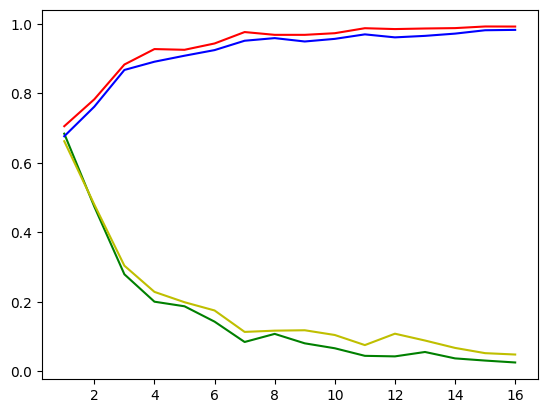

In [520]:
plot_stats(train_acc, train_loss, val_acc, val_loss)

In [521]:
loss, accuracy = stats(model, train_loader)
print(loss)
print(accuracy)

0.025564501601872982
0.9925331858407079


In [522]:
class ANet(torch.nn.Module):

    def __init__(self):
        super(ANet, self).__init__()

        self.l1 = torch.nn.Linear(3 * 128 * 128, 16 * 24 * 24)
        self.l2 = torch.nn.Linear(16 * 24 * 24, 16 * 16 * 8)
        self.l3 = torch.nn.Linear(16 * 16 * 8, 16 * 8)
        self.l4 = torch.nn.Linear(16 * 8, 1)
    
    def forward(self, x):
        x = x.view(-1, 3 * 128 * 128) 
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.sigmoid(self.l4(x))

        return x

In [523]:
model = ANet()

optimizer = torch.optim.SGD(model.parameters(), lr = LR, weight_decay = 1e-3)
loss_fn = torch.nn.BCELoss()

In [524]:
train_acc, train_loss, val_acc, val_loss = train(model, None)

EPOCH 1
LOSS train_loss = 0.6465373946502145 train_acc = 0.6960730088495575 val_loss = 0.6270689249038697 val_acc = 0.6864224137931034
EPOCH 2
LOSS train_loss = 0.5923984404158803 train_acc = 0.7164454277286135 val_loss = 0.5878766775131226 val_acc = 0.6831896551724138
EPOCH 3
LOSS train_loss = 0.5323919959827862 train_acc = 0.751198377581121 val_loss = 0.5345809449752171 val_acc = 0.7198275862068966
EPOCH 4
LOSS train_loss = 0.45883968920834295 train_acc = 0.7983960176991151 val_loss = 0.484335341056188 val_acc = 0.7553879310344828
EPOCH 5
LOSS train_loss = 0.3779512823155496 train_acc = 0.8808075221238938 val_loss = 0.4038843741019567 val_acc = 0.8243534482758621
EPOCH 6
LOSS train_loss = 0.30513000079488334 train_acc = 0.9080322025565388 val_loss = 0.3459152350823084 val_acc = 0.8609913793103449
EPOCH 7
LOSS train_loss = 0.2545724264552108 train_acc = 0.9233038348082595 val_loss = 0.2967270970344543 val_acc = 0.8836206896551724
EPOCH 8
LOSS train_loss = 0.22022557937729675 train_acc

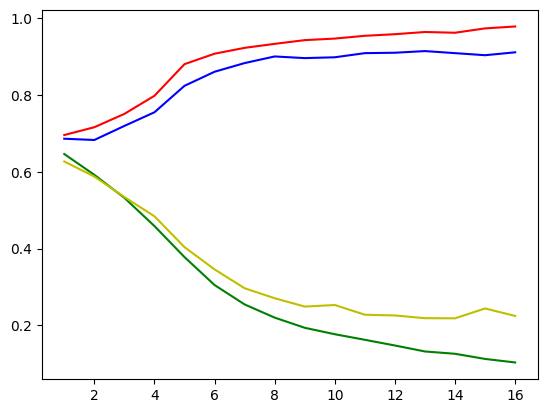

In [525]:
plot_stats(train_acc, train_loss, val_acc, val_loss)